## Setup and Imports

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import py3Dmol
import sys
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

from src.charge_steering import (
    define_hairpin_topology,
    create_hairpin_induction_interventions,
    get_baseline_structure as steering_get_baseline,
    run_intervention as steering_run_intervention,
    compute_cross_strand_distances,
    compute_backbone_hbonds,
    HairpinTopology,
)
from src.charge_repulsion import (
    define_hairpin_topology as rep_define_topology,
    create_hairpin_disruption_interventions,
    get_baseline_structure as rep_get_baseline,
    run_intervention as rep_run_intervention,
    compute_full_structure_metrics,
    NUM_BLOCKS,
)
from src.charge_dom_training import load_directions

import warnings
warnings.filterwarnings("ignore", message=".*mmCIF.*")
warnings.filterwarnings("ignore", category=UserWarning, module="Bio.PDB.DSSP")

In [6]:
from demo_utils import charge_show_protein as show_protein, charge_show_side_by_side as show_side_by_side

## Load Charge DoM Directions

Directions available for 48 blocks
Direction dim: 1024


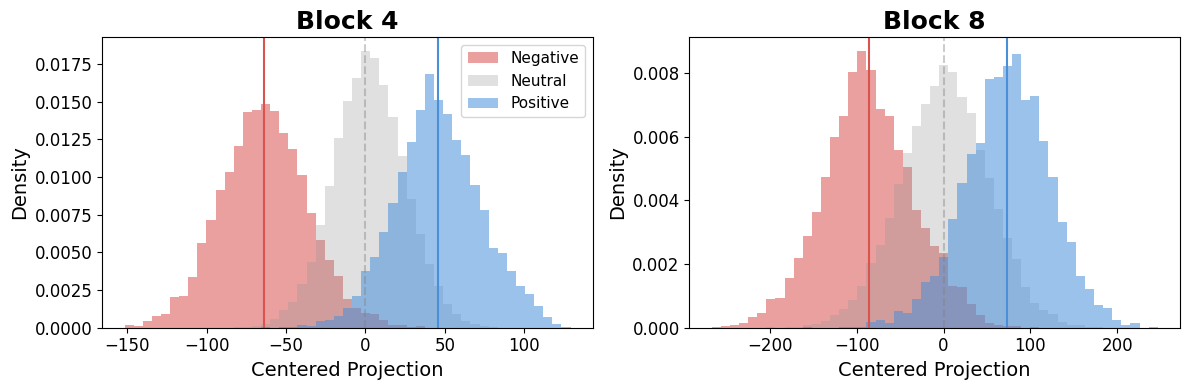

In [7]:
directions = load_directions(ROOT / "models" / "charge_directions.pt")
print(f"Directions available for {len(directions.s_directions)} blocks")
print(f"Direction dim: {len(directions.s_directions[0])}")

# Load saved projections and plot block 4 & block 8
projections = torch.load(ROOT / "models" / "projections.pt", weights_only=False)

POS_COLOR = '#4a90d9'
NEG_COLOR = '#d9534f'
NEU_COLOR = '#999999'

def _plot_block(ax, projections, block, show_legend=False):
    pos = np.array(projections[block]['positive'])
    neg = np.array(projections[block]['negative'])
    neu = np.array(projections[block]['neutral'])

    all_projs = np.concatenate([pos, neg, neu])
    center = all_projs.mean()
    pos_c, neg_c, neu_c = pos - center, neg - center, neu - center

    lo = min(pos_c.min(), neg_c.min(), neu_c.min())
    hi = max(pos_c.max(), neg_c.max(), neu_c.max())
    bins = np.linspace(lo, hi, 50)

    ax.hist(neg_c, bins=bins, alpha=0.55, color=NEG_COLOR, density=True, label='Negative')
    ax.hist(neu_c, bins=bins, alpha=0.30, color=NEU_COLOR, density=True, label='Neutral')
    ax.hist(pos_c, bins=bins, alpha=0.55, color=POS_COLOR, density=True, label='Positive')

    ax.axvline(x=neg_c.mean(), color=NEG_COLOR, linewidth=1.5)
    ax.axvline(x=pos_c.mean(), color=POS_COLOR, linewidth=1.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.4)

    ax.set_title(f'Block {block}', fontsize=18, fontweight='bold')
    ax.set_xlabel('Centered Projection', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.tick_params(labelsize=12)
    if show_legend:
        ax.legend(fontsize=11)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
_plot_block(ax1, projections, 4, show_legend=True)
_plot_block(ax2, projections, 8)
plt.tight_layout(); plt.show()

## Load Model

In [8]:
from transformers import EsmForProteinFolding, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1").to(device)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")
print(f"Model loaded on {device}")

Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda


## Charge Induction on Minimal Alpha Helix

Use a short, designed alpha-helical peptide and try to induce cross-strand
contacts via charge steering.

In [9]:
# Helix-turn-helix with stronger amphipathic helices

helix1 = "EELAKKLEELAKKLEA"   # helix with repeating E/K/L pattern
turn   = "GSG"                # flexible turn (less rigid than GPG)
helix2 = "KKALEELKKALEELKA"   # inverted charge pattern vs helix1

steer_seq = helix1 + turn + helix2  # 35 residues

# Define regions (same indexing as before)
helix1_start, helix1_end = 0, 16
turn_start, turn_end     = 16, 19
helix2_start, helix2_end = 19, 35

# Intervention hits both helices, skips the turn
intervention_residues = list(range(helix1_start, helix1_end)) + list(range(helix2_start, helix2_end))

# Block window / magnitude
win_start = 0
win_end   = 14
mag       = 0.50
pol       = "pos_neg"

print(f"Sequence:  {steer_seq}")
print(f"Length:    {len(steer_seq)}")
print(f"Helix 1:  [{helix1_start}:{helix1_end})  {helix1}")
print(f"Turn:     [{turn_start}:{turn_end})  {turn}")
print(f"Helix 2:  [{helix2_start}:{helix2_end})  {helix2}")
print(f"Intervening on {len(intervention_residues)} residues (turn excluded)")


Sequence:  EELAKKLEELAKKLEAGSGKKALEELKKALEELKA
Length:    35
Helix 1:  [0:16)  EELAKKLEELAKKLEA
Turn:     [16:19)  GSG
Helix 2:  [19:35)  KKALEELKKALEELKA
Intervening on 32 residues (turn excluded)


## Target baseline alpha helix

In [10]:
with torch.no_grad():
    baseline_out = steering_get_baseline(model, steer_seq, tokenizer, device)
baseline_pdb = model.output_to_pdb(baseline_out)[0]

region_start = helix1_start
region_end   = helix2_end

topology = HairpinTopology(
    strand1_start=helix1_start,    # 0
    strand1_end=helix1_end,        # 16
    turn_start=turn_start,         # 16
    turn_end=turn_end,             # 19
    strand2_start=helix2_start,    # 19
    strand2_end=helix2_end,        # 35
    cross_strand_pairs=[
        (helix1_start + i, helix2_end - 1 - i)
        for i in range(min(helix1_end - helix1_start, helix2_end - helix2_start))
        if helix2_end - 1 - i >= helix2_start
    ],
)


bl_hbonds = compute_backbone_hbonds(baseline_out, topology)
bl_dists  = compute_cross_strand_distances(baseline_out, topology)

print(f"Baseline: {bl_hbonds['n_hbonds']} H-bonds, "
      f"mean cross-strand dist {bl_dists['mean_cross_strand_dist']:.1f} Å")
print(f"Topology: strand1=[{topology.strand1_start}:{topology.strand1_end}), "
      f"turn=[{topology.turn_start}:{topology.turn_end}), "
      f"strand2=[{topology.strand2_start}:{topology.strand2_end})")
print(f"Cross-strand pairs: {topology.cross_strand_pairs}")

show_protein(baseline_pdb, topology)


Baseline: 0 H-bonds, mean cross-strand dist 13.0 Å
Topology: strand1=[0:16), turn=[16:19), strand2=[19:35)
Cross-strand pairs: [(0, 34), (1, 33), (2, 32), (3, 31), (4, 30), (5, 29), (6, 28), (7, 27), (8, 26), (9, 25), (10, 24), (11, 23), (12, 22), (13, 21), (14, 20), (15, 19)]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Apply Charge DoM Vector to induce hbond formation

In [11]:
intervention_blocks = set(range(win_start, win_end + 1))

s_interventions = create_hairpin_induction_interventions(
    topology=topology,
    seq_len=len(steer_seq),
    directions=directions,
    blocks=list(intervention_blocks),
    magnitude=0.63,
    device=device,
    polarity=pol,
)
with torch.no_grad():
    steered_out = steering_run_intervention(
        model, steer_seq, tokenizer, device,
        intervention_blocks=intervention_blocks,
        s_interventions=s_interventions,
    )
steered_pdb = model.output_to_pdb(steered_out)[0]

st_hbonds = compute_backbone_hbonds(steered_out, topology)
st_dists  = compute_cross_strand_distances(steered_out, topology)

print(f"Steered: {st_hbonds['n_hbonds']} H-bonds, "
      f"mean cross-strand dist {st_dists['mean_cross_strand_dist']:.1f} Å")
for i, j, bond_type, dist in st_hbonds['hbond_pairs']:
    print(f"  {bond_type} residues {i}-{j}: {dist:.2f} Å")

show_protein(steered_pdb, topology, st_hbonds['hbond_pairs'])



Steered: 4 H-bonds, mean cross-strand dist 8.5 Å
  N_i-O_j residues 4-30: 1.93 Å
  N_j-O_i residues 30-4: 3.21 Å
  N_i-O_j residues 5-29: 2.70 Å
  N_j-O_i residues 29-5: 2.19 Å


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Charge intervention brings strands closer into contact

In [12]:
show_side_by_side(
    baseline_pdb, steered_pdb, topology,
    hbond_pairs_left=bl_hbonds['hbond_pairs'],
    hbond_pairs_right=st_hbonds['hbond_pairs'],
    label_left="Baseline (helix)",
    label_right=f"Steered (blocks {win_start}-{win_end}, mag={mag})",
)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Left: Baseline (helix)  |  Right: Steered (blocks 0-14, mag=0.5)


In [13]:
print(f"{'Metric':<30} {'Baseline':>12} {'Steered':>12} {'Δ':>8}")
print("-" * 64)
print(f"{'H-bonds':<30} {bl_hbonds['n_hbonds']:>12} {st_hbonds['n_hbonds']:>12} {st_hbonds['n_hbonds'] - bl_hbonds['n_hbonds']:>+8}")
print(f"{'H-bond %':<30} {bl_hbonds['hbond_percentage']:>12.1f} {st_hbonds['hbond_percentage']:>12.1f} {st_hbonds['hbond_percentage'] - bl_hbonds['hbond_percentage']:>+8.1f}")
print(f"{'Mean cross-strand dist (Å)':<30} {bl_dists['mean_cross_strand_dist']:>12.1f} {st_dists['mean_cross_strand_dist']:>12.1f} {st_dists['mean_cross_strand_dist'] - bl_dists['mean_cross_strand_dist']:>+8.1f}")
print(f"{'Contacts (<8 Å)':<30} {bl_dists['n_contacts']:>12} {st_dists['n_contacts']:>12} {st_dists['n_contacts'] - bl_dists['n_contacts']:>+8}")
print(f"{'Mean N-O dist (Å)':<30} {bl_hbonds['mean_no_distance']:>12.1f} {st_hbonds['mean_no_distance']:>12.1f} {st_hbonds['mean_no_distance'] - bl_hbonds['mean_no_distance']:>+8.1f}")
print(f"{'Mean pLDDT':<30} {baseline_out.plddt[0].mean().item():>12.2f} {steered_out.plddt[0].mean().item():>12.2f} {steered_out.plddt[0].mean().item() - baseline_out.plddt[0].mean().item():>+8.2f}")

Metric                             Baseline      Steered        Δ
----------------------------------------------------------------
H-bonds                                   0            4       +4
H-bond %                                0.0         12.5    +12.5
Mean cross-strand dist (Å)             13.0          8.5     -4.5
Contacts (<8 Å)                           0            6       +6
Mean N-O dist (Å)                      11.6          6.4     -5.2
Mean pLDDT                             0.68         0.38    -0.30


## Charge Repulsion on Minimal Beta Hairpin

Use a short, known beta-hairpin peptide (GB1 hairpin) and try to disrupt its
cross-strand contacts via same-charge repulsion.

In [14]:
# Minimal beta-hairpin peptide (GB1 hairpin)
# One of the best-characterized hairpins in structural biology
rep_seq = "GEWTYDDATKTFTVTE"  # 16 residues

# Topology from known GB1 structure
# Strand1: EWTYD (res 1-5), Turn: DATK (res 6-9), Strand2: TFTVT (res 10-14)
rep_topology = rep_define_topology(
    hairpin_start=1,
    strand1_length=5,
    loop_length=4,
    strand2_length=5,
)
rep_hl_start = rep_topology.strand1_start
rep_hl_end   = rep_topology.strand2_end

print(f"Sequence: {rep_seq}")
print(f"Length:   {len(rep_seq)}")
print(f"Strand 1: [{rep_topology.strand1_start}, {rep_topology.strand1_end})")
print(f"Turn:     [{rep_topology.turn_start}, {rep_topology.turn_end})")
print(f"Strand 2: [{rep_topology.strand2_start}, {rep_topology.strand2_end})")
print(f"Cross-strand pairs: {rep_topology.cross_strand_pairs}")


Sequence: GEWTYDDATKTFTVTE
Length:   16
Strand 1: [1, 6)
Turn:     [6, 10)
Strand 2: [10, 15)
Cross-strand pairs: [(1, 14), (2, 13), (3, 12), (4, 11), (5, 10)]


## Baseline target hairpin

In [15]:
with torch.no_grad():
    rep_bl_out = rep_get_baseline(model, rep_seq, tokenizer, device)
rep_bl_pdb = model.output_to_pdb(rep_bl_out)[0]
rep_bl_metrics = compute_full_structure_metrics(rep_bl_out, rep_topology)
rep_bl_hbonds = compute_backbone_hbonds(rep_bl_out, rep_topology)
print(f"Baseline: mean dist={rep_bl_metrics['mean_cross_strand_dist']:.2f} Å, "
      f"H-bonds={rep_bl_metrics['n_hbonds']}, "
      f"H-bond frac={rep_bl_metrics['hbond_fraction']:.2f}")

show_protein(rep_bl_pdb, rep_topology, rep_bl_hbonds['hbond_pairs'])

Baseline: mean dist=5.73 Å, H-bonds=6, H-bond frac=0.60


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Making both strands positive causes the strands to repel!

In [16]:
CHARGE_MODE = "both_positive"
MAGNITUDE   = 0.3  # reduced for small peptide

s_ints = create_hairpin_disruption_interventions(
    topology=rep_topology,
    seq_len=len(rep_seq),
    directions=directions,
    blocks=list(range(NUM_BLOCKS)),
    magnitude=MAGNITUDE,
    intervention_config='s',
    charge_mode=CHARGE_MODE,
    device=device,
)
with torch.no_grad():
    rep_int_out = rep_run_intervention(
        model, rep_seq, tokenizer, device,
        intervention_blocks=set(range(NUM_BLOCKS)),
        s_interventions=s_ints,
    )
rep_int_pdb = model.output_to_pdb(rep_int_out)[0]
rep_int_metrics = compute_full_structure_metrics(rep_int_out, rep_topology)
rep_int_hbonds = compute_backbone_hbonds(rep_int_out, rep_topology)
dist_change  = rep_int_metrics['mean_cross_strand_dist'] - rep_bl_metrics['mean_cross_strand_dist']
hbond_change = rep_int_metrics['n_hbonds'] - rep_bl_metrics['n_hbonds']

print(f"After {CHARGE_MODE} (mag={MAGNITUDE}):")
print(f"  Mean dist: {rep_int_metrics['mean_cross_strand_dist']:.2f} Å  (Δ = {dist_change:+.2f} Å)")
print(f"  H-bonds:   {rep_int_metrics['n_hbonds']}  (Δ = {hbond_change:+d})")

show_protein(rep_int_pdb, rep_topology)


After both_positive (mag=0.3):
  Mean dist: 17.68 Å  (Δ = +11.95 Å)
  H-bonds:   0  (Δ = -6)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [17]:
show_side_by_side(
    rep_bl_pdb, rep_int_pdb, rep_topology,
    hbond_pairs_left=rep_bl_hbonds['hbond_pairs'],
    hbond_pairs_right=rep_int_hbonds['hbond_pairs'],
    label_left="Baseline (hairpin)",
    label_right=f"Disrupted ({CHARGE_MODE}, mag={MAGNITUDE})",
)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Left: Baseline (hairpin)  |  Right: Disrupted (both_positive, mag=0.3)


In [18]:
print(f"{'Metric':<30} {'Baseline':>12} {'Disrupted':>12} {'Δ':>8}")
print("-" * 64)
print(f"{'H-bonds':<30} {rep_bl_metrics['n_hbonds']:>12} {rep_int_metrics['n_hbonds']:>12} {rep_int_metrics['n_hbonds'] - rep_bl_metrics['n_hbonds']:>+8}")
print(f"{'H-bond fraction':<30} {rep_bl_metrics['hbond_fraction']:>12.2f} {rep_int_metrics['hbond_fraction']:>12.2f} {rep_int_metrics['hbond_fraction'] - rep_bl_metrics['hbond_fraction']:>+8.2f}")
print(f"{'Mean cross-strand dist (Å)':<30} {rep_bl_metrics['mean_cross_strand_dist']:>12.1f} {rep_int_metrics['mean_cross_strand_dist']:>12.1f} {rep_int_metrics['mean_cross_strand_dist'] - rep_bl_metrics['mean_cross_strand_dist']:>+8.1f}")
print(f"{'Cβ contacts (<8 Å)':<30} {rep_bl_metrics['n_cb_contacts']:>12} {rep_int_metrics['n_cb_contacts']:>12} {rep_int_metrics['n_cb_contacts'] - rep_bl_metrics['n_cb_contacts']:>+8}")
bl_plddt  = rep_bl_out.plddt[0].mean().item()
int_plddt = rep_int_out.plddt[0].mean().item()
print(f"{'Mean pLDDT':<30} {bl_plddt:>12.2f} {int_plddt:>12.2f} {int_plddt - bl_plddt:>+8.2f}")

Metric                             Baseline    Disrupted        Δ
----------------------------------------------------------------
H-bonds                                   6            0       -6
H-bond fraction                        0.60         0.00    -0.60
Mean cross-strand dist (Å)              5.7         17.7    +12.0
Cβ contacts (<8 Å)                        3            0       -3
Mean pLDDT                             0.76         0.53    -0.23


## Making Animations

In order to make the demos for social media + the website, I saved the pdbs while scaling the intervention magnitude. Afterwards, I used the scripts/render_*.py to use headless pymol for cleaner visualizations.

### Target Alpha Helix HBond Formation

In [19]:
import os

output_dir = "alpha_helical_hbond_formation"
os.makedirs(output_dir, exist_ok=True)

magnitudes = np.arange(0.025, 1, 0.015)  # 0.025, 0.05, ..., 0.5
intervention_blocks = set(range(win_start, win_end + 1))

sweep_results = []

for mag in magnitudes:
    s_interventions = create_hairpin_induction_interventions(
        topology=topology,
        seq_len=len(steer_seq),
        directions=directions,
        blocks=list(intervention_blocks),
        magnitude=mag,
        device=device,
        polarity=pol,
    )

    with torch.no_grad():
        steered_out = steering_run_intervention(
            model, steer_seq, tokenizer, device,
            intervention_blocks=intervention_blocks,
            s_interventions=s_interventions,
        )

    pdb_str = model.output_to_pdb(steered_out)[0]

    # Save PDB
    filename = f"frame_{len(sweep_results):04d}.pdb"
    with open(os.path.join(output_dir, filename), "w") as f:
        f.write(pdb_str)

    # Collect metrics
    st_hbonds = compute_backbone_hbonds(steered_out, topology)
    st_dists = compute_cross_strand_distances(steered_out, topology)

    sweep_results.append({
        'magnitude': mag,
        'n_hbonds': st_hbonds['n_hbonds'],
        'mean_cross_strand_dist': st_dists['mean_cross_strand_dist'],
    })

    print(f"mag={mag:.3f} | H-bonds={st_hbonds['n_hbonds']} | "
          f"mean dist={st_dists['mean_cross_strand_dist']:.1f} Å | saved {filename}")

    del s_interventions, steered_out
    torch.cuda.empty_cache()

sweep_df = pd.DataFrame(sweep_results)
print(f"\nSaved {len(sweep_df)} PDBs to {output_dir}/")

mag=0.025 | H-bonds=0 | mean dist=13.2 Å | saved frame_0000.pdb
mag=0.040 | H-bonds=0 | mean dist=13.3 Å | saved frame_0001.pdb
mag=0.055 | H-bonds=0 | mean dist=13.4 Å | saved frame_0002.pdb
mag=0.070 | H-bonds=0 | mean dist=13.4 Å | saved frame_0003.pdb
mag=0.085 | H-bonds=0 | mean dist=13.3 Å | saved frame_0004.pdb
mag=0.100 | H-bonds=0 | mean dist=13.4 Å | saved frame_0005.pdb
mag=0.115 | H-bonds=0 | mean dist=13.7 Å | saved frame_0006.pdb
mag=0.130 | H-bonds=0 | mean dist=13.9 Å | saved frame_0007.pdb
mag=0.145 | H-bonds=0 | mean dist=14.1 Å | saved frame_0008.pdb
mag=0.160 | H-bonds=0 | mean dist=14.1 Å | saved frame_0009.pdb
mag=0.175 | H-bonds=0 | mean dist=14.4 Å | saved frame_0010.pdb
mag=0.190 | H-bonds=0 | mean dist=14.4 Å | saved frame_0011.pdb
mag=0.205 | H-bonds=0 | mean dist=12.0 Å | saved frame_0012.pdb
mag=0.220 | H-bonds=0 | mean dist=10.6 Å | saved frame_0013.pdb
mag=0.235 | H-bonds=0 | mean dist=10.4 Å | saved frame_0014.pdb
mag=0.250 | H-bonds=0 | mean dist=10.2 Å

## Target Hairpin Strand Repulsion

In [20]:
import os

output_dir = "beta_hairpin_strand_repulsion"
os.makedirs(output_dir, exist_ok=True)

magnitudes = np.concatenate([
    np.arange(0.025, 0.120, 0.01),       # coarse ramp (~10 frames)
    np.arange(0.120, 0.127, 0.001),       # fine approach (~7 frames)
    np.arange(0.127, 0.132, 0.0002),      # ultra-fine through the break (~25 frames)
    np.arange(0.132, 0.18, 0.001),       # fine settling (~8 frames)
    # np.arange(0.140, 0.18, 0.005),       # coarse tail (~14 frames)
])
CHARGE_MODE = "both_positive"
intervention_blocks = set(range(NUM_BLOCKS))

sweep_results = []

for mag in magnitudes:
    s_ints = create_hairpin_disruption_interventions(
        topology=rep_topology,
        seq_len=len(rep_seq),
        directions=directions,
        blocks=list(intervention_blocks),
        magnitude=mag,
        intervention_config='s',
        charge_mode=CHARGE_MODE,
        device=device,
    )

    with torch.no_grad():
        rep_int_out = rep_run_intervention(
            model, rep_seq, tokenizer, device,
            intervention_blocks=intervention_blocks,
            s_interventions=s_ints,
        )

    pdb_str = model.output_to_pdb(rep_int_out)[0]

    filename = f"frame_{len(sweep_results):04d}.pdb"

    with open(os.path.join(output_dir, filename), "w") as f:
        f.write(pdb_str)

    rep_int_metrics = compute_full_structure_metrics(rep_int_out, rep_topology)
    dist_change = rep_int_metrics['mean_cross_strand_dist'] - rep_bl_metrics['mean_cross_strand_dist']
    hbond_change = rep_int_metrics['n_hbonds'] - rep_bl_metrics['n_hbonds']

    sweep_results.append({
        'magnitude': mag,
        'mean_dist': rep_int_metrics['mean_cross_strand_dist'],
        'dist_change': dist_change,
        'n_hbonds': rep_int_metrics['n_hbonds'],
        'hbond_change': hbond_change,
        'hbond_fraction': rep_int_metrics['hbond_fraction'],
    })

    print(f"mag={mag:.3f} | dist={rep_int_metrics['mean_cross_strand_dist']:.1f} Å "
          f"(Δ{dist_change:+.1f}) | H-bonds={rep_int_metrics['n_hbonds']} "
          f"(Δ{hbond_change:+d}) | saved {filename}")

    del s_ints, rep_int_out
    torch.cuda.empty_cache()

sweep_df = pd.DataFrame(sweep_results)
print(f"\nSaved {len(sweep_df)} PDBs to {output_dir}/")

mag=0.025 | dist=5.7 Å (Δ-0.0) | H-bonds=6 (Δ+0) | saved frame_0000.pdb
mag=0.035 | dist=5.7 Å (Δ-0.0) | H-bonds=6 (Δ+0) | saved frame_0001.pdb
mag=0.045 | dist=5.7 Å (Δ-0.1) | H-bonds=6 (Δ+0) | saved frame_0002.pdb
mag=0.055 | dist=5.7 Å (Δ-0.1) | H-bonds=6 (Δ+0) | saved frame_0003.pdb
mag=0.065 | dist=5.6 Å (Δ-0.1) | H-bonds=6 (Δ+0) | saved frame_0004.pdb
mag=0.075 | dist=5.6 Å (Δ-0.1) | H-bonds=6 (Δ+0) | saved frame_0005.pdb
mag=0.085 | dist=5.5 Å (Δ-0.2) | H-bonds=6 (Δ+0) | saved frame_0006.pdb
mag=0.095 | dist=5.4 Å (Δ-0.3) | H-bonds=6 (Δ+0) | saved frame_0007.pdb
mag=0.105 | dist=5.3 Å (Δ-0.4) | H-bonds=6 (Δ+0) | saved frame_0008.pdb
mag=0.115 | dist=5.4 Å (Δ-0.4) | H-bonds=6 (Δ+0) | saved frame_0009.pdb
mag=0.120 | dist=5.4 Å (Δ-0.3) | H-bonds=6 (Δ+0) | saved frame_0010.pdb
mag=0.121 | dist=5.4 Å (Δ-0.3) | H-bonds=6 (Δ+0) | saved frame_0011.pdb
mag=0.122 | dist=5.4 Å (Δ-0.3) | H-bonds=6 (Δ+0) | saved frame_0012.pdb
mag=0.123 | dist=5.5 Å (Δ-0.3) | H-bonds=6 (Δ+0) | saved frame_0